TV-Regularized 3D DiffuserCam Reconstruction
============================================

This example demonstrates reconstruction of a 3D DiffuserCam
<cite data-cite="antipa-2018-diffusercam"/>
[dataset](https://github.com/Waller-Lab/DiffuserCam/tree/master/example_data).
The inverse problem can be written as

  $$\mathrm{argmin}_{\mathbf{x}} \; \frac{1}{2} \Big\| \mathbf{y} -
  M \Big( \sum_k \mathbf{h}_k \ast \mathbf{x}_k \Big) \Big\|_2^2 +
  \lambda_0 \sum_k \| D \mathbf{x}_k \|_{2,1} +
  \lambda_1 \sum_k \| \mathbf{x}_k \|_1  \;,$$

where the $\mathbf{h}$_k are the components of the PSF stack, the
$\mathbf{x}$_k are the corrresponding components of the reconstructed
volume, $\mathbf{y}$ is the measured image, and $M$ is a cropping
operator that allows the boundary artifacts resulting from circular
convolution to be avoided. Following the mask decoupling approach
<cite data-cite="almeida-2013-deconvolving"/>, the problem is posed in ADMM form
as

  $$\mathrm{argmin}_{\mathbf{x}, \mathbf{z}_0, \mathbf{z}_1,
  \mathbf{z}_2} \; \frac{1}{2} \| \mathbf{y} - M \mathbf{z}_0 \|_2^2 +
  \lambda_0 \sum_k \| \mathbf{z}_{1,k} \|_{2,1} +
  \lambda_1 \sum_k \| \mathbf{z}_{2,k}
  \|_1  \\ \;\; \text{s.t.} \;\; \mathbf{z}_0 = \sum_k \mathbf{h}_k \ast
  \mathbf{x}_k \qquad \mathbf{z}_{1,k} = D \mathbf{x}_k \qquad
  \mathbf{z}_{2,k} = \mathbf{x}_k \;.$$

The most computationally expensive step in the ADMM algorithm is solved
using the frequency-domain approach proposed in
<cite data-cite="wohlberg-2014-efficient"/>.

In [1]:
import numpy as np

import scico.numpy as snp
from scico import plot
from scico.examples import ucb_diffusercam_data
from scico.functional import L1Norm, L21Norm, ZeroFunctional
from scico.linop import CircularConvolve, Crop, FiniteDifference, Identity, Sum
from scico.loss import SquaredL2Loss
from scico.optimize.admm import ADMM, G0BlockCircularConvolveSolver
from scico.util import device_info
plot.config_notebook_plotting()

Load the DiffuserCam PSF stack and measured image. The computational cost
of the reconstruction is reduced slightly by removing parts of the PSF
stack that don't make a significant contribution to the reconstruction.

In [2]:
y, psf = ucb_diffusercam_data()
psf = psf[..., 1:-7]

To avoid boundary artifacts, the measured image is padded by half the PSF
width/height and then cropped within the data fidelity term. This padding
is implicit in that the reconstruction volume is computed at the padded
size, but the actual measured image is never explicitly padded since it is
used at the original (unpadded) size within the data fidelity term due to
the cropping operation. The PSF axis order is modified to put the stack
axis at index 0, as required by components of the ADMM solver to be used.
Finally, each PSF in the stack is individually normalized.

In [3]:
half_psf = np.array(psf.shape[0:2]) // 2
pad_spec = ((half_psf[0],) * 2, (half_psf[1],) * 2)
y_pad_shape = tuple(np.array(y.shape) + np.array(pad_spec).sum(axis=1))
x_shape = (psf.shape[-1],) + y_pad_shape
psf = psf.transpose((2, 0, 1))
psf /= np.sqrt(np.sum(psf**2, axis=(1, 2), keepdims=True))

Convert the image and PSF stack to JAX arrays with `float32` dtype since
JAX by default does not support double-precision floating point
arithmetic. This limited precision leads to relatively poor, but still
acceptable accuracy within the ADMM solver x-step. To experiment with the
effect of higher numerical precision, set the environment variable
`JAX_ENABLE_X64=True` and change `dtype` below to `np.float64`.

In [4]:
dtype = np.float32
y = snp.array(y.astype(dtype))
psf = snp.array(psf.astype(dtype))

Define problem and algorithm parameters.

In [5]:
λ0 = 3e-3  # TV regularization parameter
λ1 = 1e-2  # ℓ1 norm regularization parameter
ρ0 = 1e0  # ADMM penalty parameter for first auxiliary variable
ρ1 = 5e0  # ADMM penalty parameter for second auxiliary variable
ρ2 = 1e1  # ADMM penalty parameter for third auxiliary variable
maxiter = 100  # number of ADMM iterations

Create operators.

In [6]:
C = CircularConvolve(psf, input_shape=x_shape, input_dtype=dtype, h_center=half_psf, ndims=2)
S = Sum(input_shape=x_shape, input_dtype=dtype, axis=0)
M = Crop(pad_spec, input_shape=y_pad_shape, input_dtype=dtype)

Create functionals.

In [7]:
g0 = SquaredL2Loss(y=y, A=M)
g1 = λ0 * L21Norm()
g2 = λ1 * L1Norm()
C0 = S @ C
C1 = FiniteDifference(input_shape=x_shape, input_dtype=dtype, axes=(-2, -1), circular=True)
C2 = Identity(input_shape=x_shape, input_dtype=dtype)

Set up ADMM solver object and solve problem.

In [8]:
solver = ADMM(
    f=ZeroFunctional(),
    g_list=[g0, g1, g2],
    C_list=[C0, C1, C2],
    rho_list=[ρ0, ρ1, ρ2],
    alpha=1.4,
    maxiter=maxiter,
    nanstop=True,
    subproblem_solver=G0BlockCircularConvolveSolver(ndims=2, check_solve=True),
    itstat_options={"display": True, "period": 10},
)

print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Prml Rsdl  Dual Rsdl  Slv Res  
----------------------------------------------------------
   0  8.65e+00  1.587e+03  5.634e+01  2.962e+04  0.000e+00


  10  1.12e+01  4.494e+00  3.557e-01  2.244e+02  2.836e-03


  20  1.19e+01  4.323e+00  2.498e-01  2.690e+02  3.450e-03


  30  1.26e+01  4.361e+00  1.958e-01  2.198e+02  2.827e-03


  40  1.33e+01  4.487e+00  1.501e-01  1.659e+02  2.251e-03


  50  1.40e+01  4.519e+00  1.245e-01  1.268e+02  1.909e-03


  60  1.47e+01  4.570e+00  1.138e-01  1.325e+02  2.128e-03


  70  1.54e+01  4.645e+00  1.158e-01  1.612e+02  2.396e-03


  80  1.61e+01  4.713e+00  9.262e-02  8.807e+01  1.359e-03


  90  1.68e+01  4.803e+00  1.013e-01  1.545e+02  2.388e-03


  99  1.74e+01  4.885e+00  8.366e-02  1.070e+02  2.079e-03


Show the measured image and samples from PDF stack

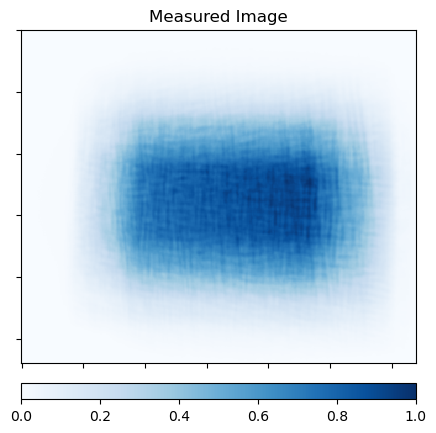

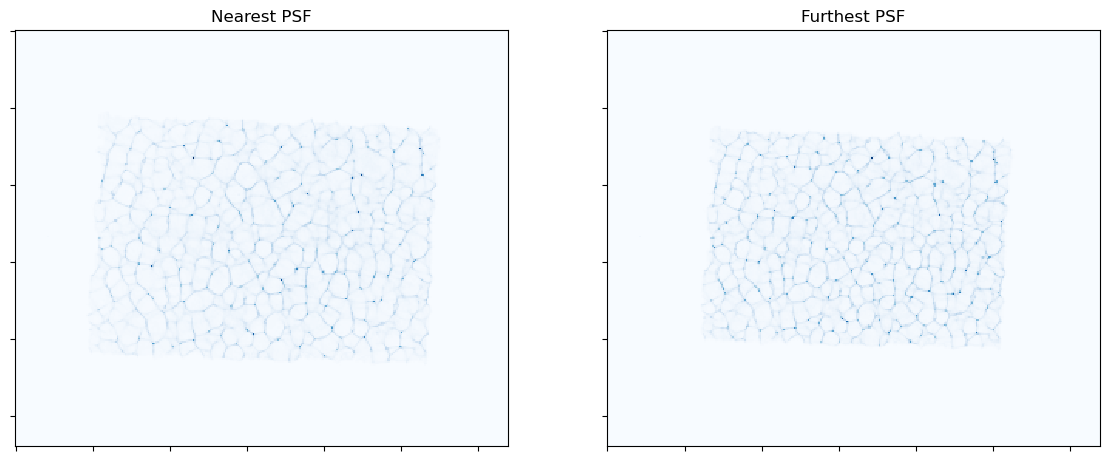

In [9]:
plot.imview(y, cmap=plot.plt.cm.Blues, cbar=True, title="Measured Image")

fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot.imview(psf[0], title="Nearest PSF", cmap=plot.plt.cm.Blues, fig=fig, ax=ax[0])
plot.imview(psf[-1], title="Furthest PSF", cmap=plot.plt.cm.Blues, fig=fig, ax=ax[1])
fig.show()

Show the recovered volume with depth indicated by color.

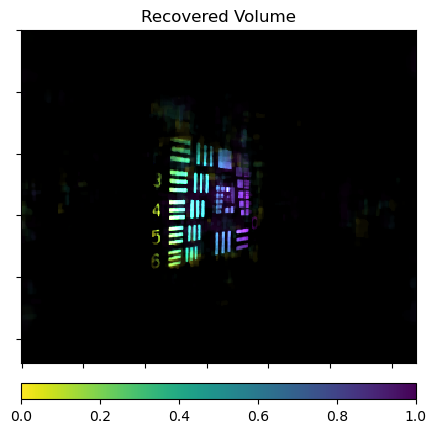

In [10]:
XCrop = Crop(((0, 0),) + pad_spec, input_shape=x_shape, input_dtype=dtype)
xm = np.array(XCrop(x[..., ::-1]))
xmr = xm.transpose((1, 2, 0))[..., np.newaxis] / xm.max()
cmap = plot.plt.cm.viridis_r
cmval = cmap(np.arange(0, xm.shape[0]).reshape(1, 1, -1) / (xm.shape[0] - 1))
xms = np.sum(cmval * xmr, axis=2)[..., 0:3]

plot.imview(xms, cmap=cmap, cbar=True, title="Recovered Volume")

Plot convergence statistics.

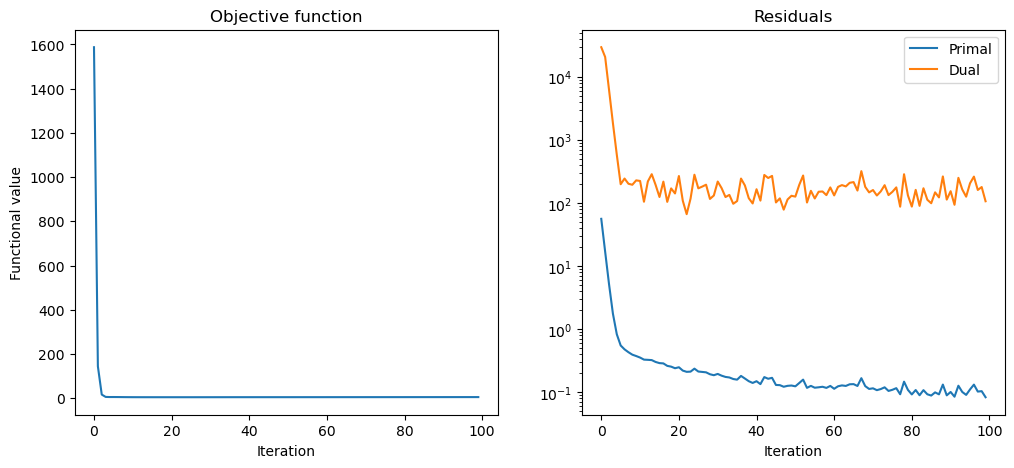

In [11]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    hist.Objective,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    fig=fig,
    ax=ax[0],
)
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
    fig=fig,
    ax=ax[1],
)
fig.show()